In [1]:
from src.dataset.campus import Campus
from src.box_clustering import multiViewHumanBoxesClustering
from src.multiview_3d import solveMultiView3DHumanPoses
from src.bundle_adjustment import bundleAdjustmentWrapper
from src.plot_functions import *
from src.evaluate import *
import yaml

data_dir = './data/campus'
config = yaml.safe_load(open('./config/campus.yml', 'r'))
dataset = Campus(data_dir, config=config)
frame_id = 718
wrld_cam_id = 0


# --- Step 1: crop bounding box
boxcrop_dir = dataset.getSingleFrameMultiViewBoxes(frame_id)
box_reid_feat = dataset.getFrameReIDFeat(frame_id)

# # --- Step 2: cluster boxes using re-ID feature
boxfile_clusters = multiViewHumanBoxesClustering(
    box_reid_feat, size_max=dataset.num_cam,
    method='kmeans_ssc')

# --- Step 3: generate 2D-2D point correpondences
pts_corresp_dict, n_persons = dataset.genPtsCorrepFromBoxClus(
    boxfile_clusters)

# # --- Step 4: solve 3D human pose
Pts, BA_input, wrld_cam_name = solveMultiView3DHumanPoses(
    pts_corresp_dict, dataset.cam_params_dict, n_persons,
    Pts_prev=None, wrld_cam_id=wrld_cam_id)

# --- Step 5: bundle adjustement
Pts_BA, M2s_BA = bundleAdjustmentWrapper(
    BA_input, fix_cam_pose=False, wrld_cam_id=wrld_cam_id)


Perform clustering:
[0.01 seconds] "kmeans_ssc" | "cosine" | 3 clusters.

Method         Distance       Purity    RI        ARI       F_Score   
kmeans_ssc     cosine         1.000     1.000     1.000     1.000     


Solve 3D human and camera poses:
This person is invisible from the world camera.
This person is invisible from the world camera.
Done.
Ref cam id:0, name:0


Bundle adjustment:
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         5.3504e+05                                    4.52e+06    
       1              2         1.5097e+04      5.20e+05       2.65e-01       8.92e+05    
       2              3         1.0422e+02      1.50e+04       1.24e-01       5.11e+04    
       3              4         3.4090e+01      7.01e+01       7.63e-02       1.47e+04    
       4              5         2.4627e+01      9.46e+00       1.90e-03       7.35e+00    
       5              6         2.4627e+01      1.07e-04  

Plot joints in campus | camera Camera0 | frame 718.
Plot joints in campus | camera Camera1 | frame 718.
Plot joints in campus | camera Camera2 | frame 718.


(<Figure size 432x288 with 1 Axes>, <Axes3DSubplot:>)

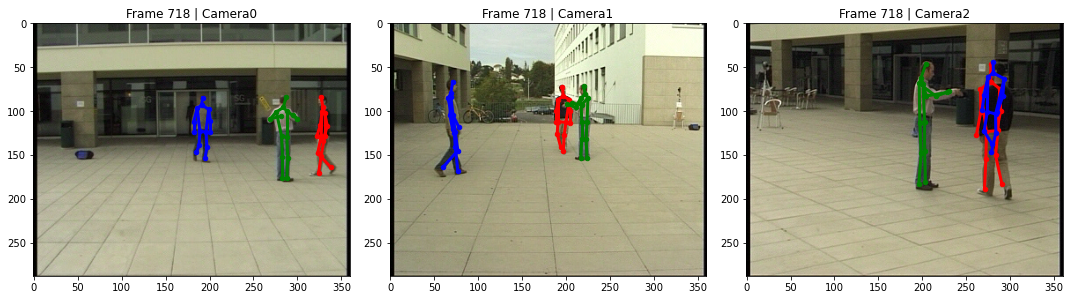

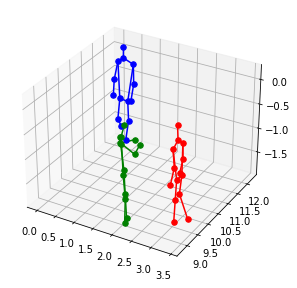

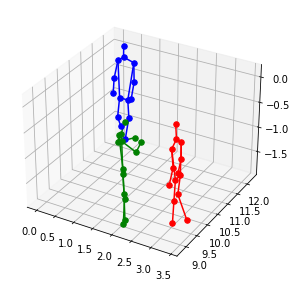

In [2]:
# --- Visualize 2D pose
plotSingleFrameMultiView2dJoints(
    dataset, frame_id, plot_joint_id=False, save_plot=True)

rot_x = 0
rot_z = 180
xlim, ylim, zlim = None, None, None

Pts_world = dataset.convertToWrldCoord(Pts, wrld_cam_name)
_, Pts_world, _, _ = dataset.alignEstAndGTCoords(frame_id, Pts, wrld_cam_name)
# Pts_world = b3dop.rotate3DPtsAroundZ(b3dop.rotate3DPtsAroundX(Pts_world.T, rot_x), rot_z).T
plotMulti3DHumanPoses(Pts_world, n_persons, dataset.body_edges, plt_jnt_id=False, show_label=True,
                      xlim=xlim, ylim=ylim, zlim=zlim)

Pts_w_gt, Pts_w_est, _, scale = dataset.alignEstAndGTCoords(frame_id, Pts_BA, wrld_cam_name)
# Pts_w_est = b3dop.rotate3DPtsAroundZ(b3dop.rotate3DPtsAroundX(Pts_w_est.T, rot_x), rot_z).T
plotMulti3DHumanPoses(Pts_w_est, n_persons, dataset.body_edges, plt_jnt_id=False, show_label=True,
                      xlim=xlim, ylim=ylim, zlim=zlim)